In [1]:
from keras.applications import inception_v3
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
from skimage import io,transform
import os
import sys
model_name = 'InceptionV3Tuned_RealSpam'

Using TensorFlow backend.


In [2]:
# size = 299
# counter = 0
# spamFolder = '../Images/SpamReal/Spam/'
# imageFiles = os.listdir(spamFolder)
# total = len(imageFiles)
# spam_images = []
# for image_path in imageFiles:
#     if not image_path.endswith('.jpg'):
#         continue
#     img = io.imread(os.path.join(spamFolder,image_path))
#     img = transform.resize(img, (size,size,3))
#     spam_images.append(img)
#     counter += 1
#     sys.stdout.write("\rProcessed: {0}/{1}".format(counter, total))
#     sys.stdout.flush()
# print('')
# counterA = 0
# realFolder = '../Images/SpamReal/Real/'
# imageFiles = os.listdir(realFolder)
# total = len(imageFiles)    
# real_images = []
# for image_path in os.listdir(realFolder):
#     if not image_path.endswith('.jpg'):
#         continue
#     img = io.imread(os.path.join(realFolder,image_path))
#     img = transform.resize(img, (size,size,3))
#     real_images.append(img)
#     counterA += 1
#     sys.stdout.write("\rProcessed: {0}/{1}".format(counterA, total))
#     sys.stdout.flush()
    
# x = np.array(spam_images+real_images)
# y = np.array(([0] * len(spam_images)) + ([1] * len(real_images)))
# y = keras.utils.to_categorical(y, 2)

# import random
# c = list(zip(x, y))
# random.shuffle(c)
# x, y = zip(*c)
# x = np.array(x)
# y = np.array(y)
# np.save('../Images/SpamReal/spamreal_x%s.npy' % size, x)
# np.save('../Images/SpamReal/spamreal_y%s.npy' % size, y)

In [3]:
size=299
x = np.load('../Images/SpamReal/spamreal_x%s.npy' % size)
y = np.load('../Images/SpamReal/spamreal_y%s.npy' % size)

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

In [5]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model
base = inception_v3.InceptionV3(include_top=False, classes=2, input_shape=(size,size,3), pooling='avg')
temp = base.output
# temp = GlobalAveragePooling2D()(temp)
temp = Dropout(0.5)(temp)
predictions = Dense(2, activation= 'softmax')(temp)
model = Model(inputs = base.input, outputs = predictions)

In [31]:
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
# rmsp = rmsprop(lr=0.01, decay=0.9, epsilon=1, clipvalue=2)
model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

filepath="%s.best.hdf5" % model_name
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

hist = model.fit([x_train], y_train, batch_size=32, epochs=20, validation_data=([x_test], y_test), verbose=1, callbacks=callbacks_list)

Train on 8397 samples, validate on 2100 samples
Epoch 1/20
8397/8397 [==============================] - 123s 15ms/step - loss: 0.2234 - acc: 0.9031 - val_loss: 0.1227 - val_acc: 0.9495

Epoch 00001: val_loss improved from inf to 0.12266, saving model to InceptionV3Tuned_RealSpam.best.hdf5
Epoch 2/20
8397/8397 [==============================] - 113s 14ms/step - loss: 0.0969 - acc: 0.9634 - val_loss: 0.1022 - val_acc: 0.9590

Epoch 00002: val_loss improved from 0.12266 to 0.10216, saving model to InceptionV3Tuned_RealSpam.best.hdf5
Epoch 3/20
8397/8397 [==============================] - 115s 14ms/step - loss: 0.0420 - acc: 0.9864 - val_loss: 0.1066 - val_acc: 0.9610

Epoch 00003: val_loss did not improve from 0.10216
Epoch 4/20
8397/8397 [==============================] - 114s 14ms/step - loss: 0.0202 - acc: 0.9944 - val_loss: 0.1343 - val_acc: 0.9524

Epoch 00004: val_loss did not improve from 0.10216
Epoch 5/20
8397/8397 [==============================] - 113s 14ms/step - loss: 0.0135 

In [32]:
# serialize model to JSON
model_json = model.to_json()
with open("%s.json" % model_name, "w") as json_file:
    json_file.write(model_json)
    
# # serialize weights to HDF5
model.save_weights("%s.h5" % model_name)
print("Saved model to disk")

Saved model to disk


In [ ]:
from keras.models import model_from_json
# load json and create model
json_file = open('%s.json' % model_name, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("%s.h5" % model_name)
print("Loaded model from disk")

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

In [ ]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score

predicted = model.predict([x_test])
true = []
pred = []
for i in range(len(predicted)):
    p_tmp = np.argmax(predicted[i], axis=-1)
    t_tmp = np.argmax(y_test[i], -1)
    pred.append(p_tmp)
    true.append(t_tmp)

print(precision_score(true, pred))
print(recall_score(true, pred))
print(roc_auc_score(true, pred))
print(f1_score(true, pred))

In [35]:
from keras.models import model_from_json
# load json and create model
json_file = open('%s.json' % model_name, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("%s.best.hdf5" % model_name)
print("Loaded model from disk")

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

Loaded model from disk


In [22]:
# predicted = model.predict([x_test])
true = []
pred = []
for i in range(len(predicted)):
    p_tmp = predicted[i][1]
    t_tmp = np.argmax(y_test[i], -1)
    pred.append(p_tmp)
    true.append(t_tmp)
true = np.array(true)
pred = np.array(pred)
print(precision_score(true, pred>=0.362))
print(recall_score(true, pred>=0.362))
print(roc_auc_score(true, pred))
print(f1_score(true, pred>=0.362))

0.9628865979381444
0.9569672131147541
0.9925516670555977
0.959917780061665


In [21]:
np.save('InceptionV3_RealSpam-Tuned_True.npy', np.array(true))
np.save('InceptionV3_RealSpam-Tuned_Pred.npy', np.array(pred))

In [9]:
from sklearn.metrics import classification_report
print(classification_report(true, pred, digits=3))

             precision    recall  f1-score   support

          0      0.956     0.973     0.965      1124
          1      0.969     0.949     0.959       976

avg / total      0.962     0.962     0.962      2100



In [37]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, _ = roc_curve(true, predicted[:,1])
np.save('fpr_%s.npy' % model_name, fpr)
np.save('tpr_%s.npy' % model_name, tpr)

In [3]:
y_tr = np.load('InceptionV3_RealSpam-Tuned_True.npy')
y_pr = np.load('InceptionV3_RealSpam-Tuned_Pred.npy')

In [9]:
y_pred = np.array(list(zip(1-y_pr, y_pr)))
y_pred

array([[9.9999791e-01, 2.1095905e-06],
       [1.1600453e-01, 8.8399547e-01],
       [9.9261487e-01, 7.3851091e-03],
       ...,
       [9.9979097e-01, 2.0903470e-04],
       [0.0000000e+00, 1.0000000e+00],
       [1.1920929e-07, 9.9999988e-01]], dtype=float32)

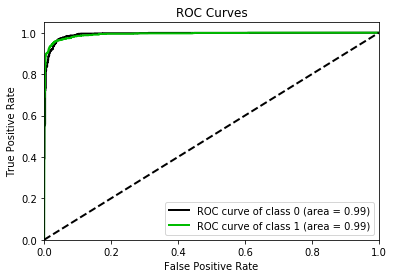

In [14]:
%matplotlib inline
import scikitplot as skplt
skplt.metrics.plot_roc(y_tr, y_pred, plot_micro=False, plot_macro=False)

In [22]:
import matplotlib.pyplot as plt

In [28]:
!pip3 install pyperclip --user

You are using pip version 19.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [35]:
import sys

In [38]:
sys.version_info

sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)

In [41]:
!python3.5 -m pip install pyperclip --user

You are using pip version 19.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [43]:
pd.DataFrame(dict(y_tr=y_tr, y_pred=np.round(y_pred[:,1]))).to_csv("binary_inc3t.csv")

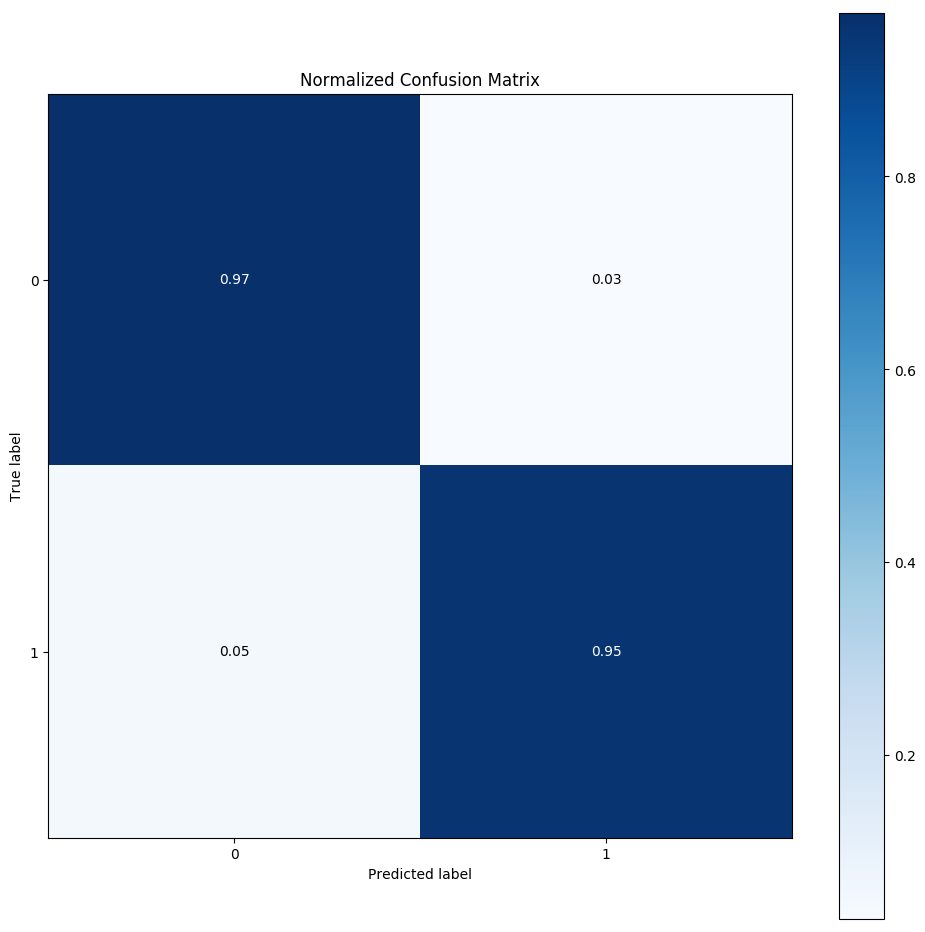

In [23]:
ax = plt.figure(figsize=(12, 12), dpi=100).gca()
skplt.metrics.plot_confusion_matrix(y_tr, np.round(y_pred[:,1]), normalize=True, ax=ax)